# Latent LSTM

In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

# from src.utils.data_utils import TGIF
from src.utils.data_utils import MMNist
from src.utils.gan_trainer import ModelTrainer
from src.utils.initializer import Initializer

from src.models.latent_lstm_vaegan import LatentLSTM
from src.models.vaegan import VAEGAN_Disc, Initializer

from src.utils.vis_utils import *

import numpy as np
import os

%load_ext autoreload
%autoreload 2

TEST_MODEL_PATH = os.path.join(os.getcwd(), 'src', 'experiments', 'latent-lstm-gan')

In [2]:
USE_GPU = True

dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using device:', device)
print('Using type:', dtype)

Using device: cuda
Using type: torch.float32


In [3]:
IMAGE_SZ = (64, 64)
MAX_FRAMES = 10
DATASET_ROOT = '/home/deepdeepfakes/cs231n-project/src/datasets/MMNIST'
TRANSFORMS = transforms.Compose([
#                         transforms.Resize(IMAGE_SZ),                   
                        transforms.ToTensor()
                        ])

train_set = MMNist(f'{DATASET_ROOT}/train_set.npz', temporality=True, transform=TRANSFORMS)
val_set = MMNist(f'{DATASET_ROOT}/val_set.npz', temporality=True, transform=TRANSFORMS)

In [4]:
BATCH_SZ = 32
NUM_WORKERS = 4


train_loader = DataLoader(train_set, batch_size=BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_set, batch_size=BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)

print(len(train_set), len(val_set)) #, len(test_set))

80000 10000


In [5]:
# %matplotlib inline

# dataiter = iter(train_loader)
# gif = dataiter.next()[0]
    
# imshow(torchvision.utils.make_grid(gif))

In [6]:
DISP_LIM = 16

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled


def make_gif(model, seed_frame, curr_h=None, gif_length=20):
    if not curr_h:
        curr_h = model.init_hidden(BATCH_SZ)
        
    curr_x = seed_frame.to(device=device, dtype=dtype)
    ret = [seed_frame]
    
    for i in range(gif_length - 1): 
        y, curr_h = model(curr_x, curr_h)
        curr_x = y
        ret.append(y.to(device = torch.device('cpu')))
    
    return torch.stack(ret).transpose(0, 1).squeeze()

def test_lstm_eval(model, loader):
    model.eval()
    dataiter = iter(loader)
    x = dataiter.next()
    
    seeds = x[:, 0, :, :, :]
    seeds = seeds.unsqueeze(1)
    gif = make_gif(model, seeds)
    
    orig_gifs = torch.cat(tuple(x))[:DISP_LIM]
    out_gifs = torch.cat(tuple(gif))[:DISP_LIM]
    out_gifs = out_gifs.clamp(0, 1).unsqueeze(1)
    
    img_show(torchvision.utils.make_grid(orig_gifs))
    img_show(torchvision.utils.make_grid(out_gifs.detach()))

    
def first_frame_hidden_state(model, first_seeds):
    curr_h = model.init_hidden(BATCH_SZ)
    curr_x = first_seeds.to(device=device, dtype=dtype)
    
    _, curr_h = model(curr_x, curr_h)
    
    return curr_h


    
def test_lstm_eval_2(model, loader):
    model.eval()
    dataiter = iter(loader)
    x = dataiter.next()
    
    throwaway_seeds = x[:, 0, :, :, :]
    throwaway_seeds = throwaway_seeds.unsqueeze(1)
    
    curr_h = first_frame_hidden_state(model, throwaway_seeds)    
    
    
    seeds = x[:, 1, :, :, :]
    seeds = seeds.unsqueeze(1)
    gif = make_gif(model, seeds, curr_h=curr_h)
    
    orig_gifs = torch.cat(tuple(x))[:DISP_LIM]
    out_gifs = torch.cat(tuple(gif))[:DISP_LIM]
    out_gifs = out_gifs.clamp(0, 1).unsqueeze(1)
    
    img_show(torchvision.utils.make_grid(orig_gifs))
    img_show(torchvision.utils.make_grid(out_gifs.detach()))    
    
    
def test_lstm_train(model, loader):
    model.train()
    dataiter = iter(loader)
    x = dataiter.next()
    x = x.to(device=device)
    
    orig_gifs = torch.cat(tuple(x))[:DISP_LIM]
    orig_gifs = orig_gifs.cpu().detach()
    
    out_gifs, hidden_out = model(x, model.init_hidden(BATCH_SZ))
    out_gifs = out_gifs[0]
    out_gifs = out_gifs.clamp(0, 1)
    out_gifs = out_gifs.cpu().detach()[:DISP_LIM]  
    
    img_show(torchvision.utils.make_grid(orig_gifs))
    img_show(torchvision.utils.make_grid(out_gifs)) 

In [8]:
def train_fn(gen_model, disc_model, gen_optimizer, disc_optimizer, x):
    
    N, T, C, H, W = x.shape
    
    criterion = nn.BCEWithLogitsLoss(size_average=True)
    gan_reg = 3e-4
    kl_reg = 1e-8
    disc_err_fake_reg = 1
    
    h0 = gen_model.init_hidden(BATCH_SZ)
    
    gen_model.train()
    disc_model.train()            

    disc_optimizer.zero_grad()

    x = x.to(device=device, dtype=dtype)
    
    next_frames, _ = gen_model(x, h0)
    
    orig_x = x[:, 1:, :]
    recon_x = next_frames[:, :-1, :]
    
    logits_real = disc_model(orig_x.contiguous().view(-1, C, H, W)).squeeze()
    logits_fake = disc_model(recon_x.contiguous().view(-1, C, H, W)).squeeze()
    
    all_ones = torch.ones(logits_real.shape[0], device=device)
    all_zeros = torch.zeros(logits_real.shape[0], device=device)
    
    disc_err_real = criterion(logits_real, all_ones)
    disc_err_fake = disc_err_fake_reg * criterion(logits_fake, all_zeros)    
    
    disc_loss = disc_err_real + disc_err_fake    
    
    disc_loss.backward()
    disc_optimizer.step()    
    
    
    # generator loss
    gen_optimizer.zero_grad()    
    
    next_frames, _ = gen_model(x, h0)
    recon_x = next_frames[:, :-1, :]
    
    gen_logits_fake = disc_model(recon_x.contiguous().view(-1, C, H, W)).squeeze()
    gen_loss_gan = gan_reg * criterion(gen_logits_fake, all_ones)    
    
    MSE = F.mse_loss(orig_x, recon_x, size_average=True)
    
    gen_loss = MSE + gen_loss_gan
    
    gen_loss.backward()
    gen_optimizer.step()
    
    gen_loss_str = f'recr: {MSE:.6f}, gan: {gen_loss_gan:.6f}'
    disc_loss_str = f'real: {disc_err_real:.6f}, fake: {disc_err_fake:.6f}'    
    
    return gen_loss, disc_loss, gen_loss_str, disc_loss_str

In [9]:
NUM_CHANNELS = 1
INPUT_SIZE = IMAGE_SZ[0] * IMAGE_SZ[1] * NUM_CHANNELS   
HIDDEN_SIZE = INPUT_SIZE
OUTPUT_SIZE = INPUT_SIZE


LATENT_SIZE = 95

gen = LatentLSTM(latent_size=LATENT_SIZE, hidden_size=200, device=device, num_channels=NUM_CHANNELS, num_rnn_layers=1)
disc = VAEGAN_Disc(latent_size=LATENT_SIZE, device=device, num_channels=NUM_CHANNELS)

Initializer.initialize(model=gen, initialization=init.xavier_uniform_, gain=init.calculate_gain('relu'))
Initializer.initialize(model=disc, initialization=init.xavier_uniform_, gain=init.calculate_gain('relu'))


BEST_VAEGAN_PATH = '/home/deepdeepfakes/cs231n-project/src/backups/vaegan-mmnist/vaegan-best'
state = torch.load(BEST_VAEGAN_PATH)

# gen.vae.load_state_dict(state['gen_state_dict'])
# disc.load_state_dict(state['disc_state_dict'])



param_count = np.sum([np.prod(p.size()) for p in gen.parameters()])
print(f'Num parameters: {param_count}')



# ModelTrainer.load_model(checkpoint_path=BEST_VAEGAN_PATH, model=model.vae)

Num parameters: 3586035


In [10]:
LSTM_DEBUG_ROOT = os.path.join(os.getcwd(), 'src', 'experiments', 'latent-lstm-xavier-no-init-long-train')

gen_optimizer = optim.Adam(gen.parameters(), lr=1e-3)
disc_optimizer = optim.Adam(disc.parameters(), lr=1e-3)

trainer = ModelTrainer(gen, disc, gen_optimizer, disc_optimizer, train_fn, LSTM_DEBUG_ROOT, tags=["lstm", "lstm-gan", "lstm-gan-xavier-no-init"])


In [11]:
trainer.train(train_loader, verbose=True, epochs=10, print_every=50)
trainer.save_data(force_save=True)

Epoch [0] (0/2500), 	 gen_loss  = 0.4599 	(recr: 0.459597, gan: 0.000281), 
			 disc_loss = 1.6948 	(real: 0.891269, fake: 0.803512)

Epoch [0] (50/2500), 	 gen_loss  = 0.0378 	(recr: 0.037394, gan: 0.000391), 
			 disc_loss = 0.7337 	(real: 0.382829, fake: 0.350847)

Epoch [0] (100/2500), 	 gen_loss  = 0.0356 	(recr: 0.034948, gan: 0.000643), 
			 disc_loss = 0.3024 	(real: 0.153062, fake: 0.149337)

Epoch [0] (150/2500), 	 gen_loss  = 0.0329 	(recr: 0.032128, gan: 0.000819), 
			 disc_loss = 0.1461 	(real: 0.068129, fake: 0.077982)

Epoch [0] (200/2500), 	 gen_loss  = 0.0300 	(recr: 0.029429, gan: 0.000568), 
			 disc_loss = 0.8331 	(real: 0.039709, fake: 0.793357)

Epoch [0] (250/2500), 	 gen_loss  = 0.0322 	(recr: 0.031252, gan: 0.000908), 
			 disc_loss = 0.1585 	(real: 0.077263, fake: 0.081267)

Epoch [0] (300/2500), 	 gen_loss  = 0.0308 	(recr: 0.029672, gan: 0.001101), 
			 disc_loss = 0.0889 	(real: 0.055131, fake: 0.033805)

Epoch [0] (350/2500), 	 gen_loss  = 0.0275 	(recr: 

Epoch [1] (500/2500), 	 gen_loss  = 0.0235 	(recr: 0.020930, gan: 0.002619), 
			 disc_loss = 0.0005 	(real: 0.000199, fake: 0.000280)

Epoch [1] (550/2500), 	 gen_loss  = 0.0248 	(recr: 0.022183, gan: 0.002632), 
			 disc_loss = 0.0004 	(real: 0.000168, fake: 0.000231)

Epoch [1] (600/2500), 	 gen_loss  = 0.0251 	(recr: 0.022447, gan: 0.002629), 
			 disc_loss = 0.0005 	(real: 0.000179, fake: 0.000290)

Epoch [1] (650/2500), 	 gen_loss  = 0.0233 	(recr: 0.021180, gan: 0.002143), 
			 disc_loss = 0.0045 	(real: 0.001014, fake: 0.003534)

Epoch [1] (700/2500), 	 gen_loss  = 0.0250 	(recr: 0.023298, gan: 0.001720), 
			 disc_loss = 0.0121 	(real: 0.006241, fake: 0.005895)

Epoch [1] (750/2500), 	 gen_loss  = 0.0218 	(recr: 0.019947, gan: 0.001866), 
			 disc_loss = 0.0051 	(real: 0.002221, fake: 0.002844)

Epoch [1] (800/2500), 	 gen_loss  = 0.0233 	(recr: 0.021258, gan: 0.002003), 
			 disc_loss = 0.0037 	(real: 0.001952, fake: 0.001741)

Epoch [1] (850/2500), 	 gen_loss  = 0.0229 	(rec

Epoch [2] (1000/2500), 	 gen_loss  = 0.0200 	(recr: 0.018020, gan: 0.001991), 
			 disc_loss = 0.0033 	(real: 0.001359, fake: 0.001976)

Epoch [2] (1050/2500), 	 gen_loss  = 0.0200 	(recr: 0.018024, gan: 0.001961), 
			 disc_loss = 0.0027 	(real: 0.000829, fake: 0.001899)

Epoch [2] (1100/2500), 	 gen_loss  = 0.0189 	(recr: 0.016853, gan: 0.002051), 
			 disc_loss = 0.0023 	(real: 0.000844, fake: 0.001449)

Epoch [2] (1150/2500), 	 gen_loss  = 0.0189 	(recr: 0.016822, gan: 0.002047), 
			 disc_loss = 0.0031 	(real: 0.001651, fake: 0.001442)

Epoch [2] (1200/2500), 	 gen_loss  = 0.0191 	(recr: 0.017118, gan: 0.002021), 
			 disc_loss = 0.0026 	(real: 0.000602, fake: 0.001963)

Epoch [2] (1250/2500), 	 gen_loss  = 0.0202 	(recr: 0.018142, gan: 0.002043), 
			 disc_loss = 0.0022 	(real: 0.000634, fake: 0.001532)

Epoch [2] (1300/2500), 	 gen_loss  = 0.0194 	(recr: 0.017348, gan: 0.002052), 
			 disc_loss = 0.0021 	(real: 0.000565, fake: 0.001550)

Epoch [2] (1350/2500), 	 gen_loss  = 0.01

Epoch [3] (1500/2500), 	 gen_loss  = 0.0181 	(recr: 0.015388, gan: 0.002724), 
			 disc_loss = 0.0003 	(real: 0.000113, fake: 0.000169)

Epoch [3] (1550/2500), 	 gen_loss  = 0.0185 	(recr: 0.015739, gan: 0.002773), 
			 disc_loss = 0.0002 	(real: 0.000091, fake: 0.000132)

Epoch [3] (1600/2500), 	 gen_loss  = 0.0194 	(recr: 0.016451, gan: 0.002907), 
			 disc_loss = 0.0049 	(real: 0.004667, fake: 0.000242)

Epoch [3] (1650/2500), 	 gen_loss  = 0.0182 	(recr: 0.015389, gan: 0.002817), 
			 disc_loss = 0.0004 	(real: 0.000172, fake: 0.000209)

Epoch [3] (1700/2500), 	 gen_loss  = 0.0190 	(recr: 0.016149, gan: 0.002864), 
			 disc_loss = 0.0004 	(real: 0.000283, fake: 0.000140)

Epoch [3] (1750/2500), 	 gen_loss  = 0.0191 	(recr: 0.016191, gan: 0.002879), 
			 disc_loss = 0.0002 	(real: 0.000119, fake: 0.000119)

Epoch [3] (1800/2500), 	 gen_loss  = 0.0181 	(recr: 0.015269, gan: 0.002794), 
			 disc_loss = 0.0003 	(real: 0.000127, fake: 0.000137)

Epoch [3] (1850/2500), 	 gen_loss  = 0.01

Epoch [4] (2000/2500), 	 gen_loss  = 0.0187 	(recr: 0.015717, gan: 0.002934), 
			 disc_loss = 0.0001 	(real: 0.000039, fake: 0.000095)

Epoch [4] (2050/2500), 	 gen_loss  = 0.0182 	(recr: 0.014761, gan: 0.003417), 
			 disc_loss = 0.0001 	(real: 0.000114, fake: 0.000020)

Epoch [4] (2100/2500), 	 gen_loss  = 0.0178 	(recr: 0.014474, gan: 0.003363), 
			 disc_loss = 0.0001 	(real: 0.000036, fake: 0.000028)

Epoch [4] (2150/2500), 	 gen_loss  = 0.0181 	(recr: 0.014862, gan: 0.003277), 
			 disc_loss = 0.0001 	(real: 0.000065, fake: 0.000026)

Epoch [4] (2200/2500), 	 gen_loss  = 0.0176 	(recr: 0.014205, gan: 0.003411), 
			 disc_loss = 0.0001 	(real: 0.000045, fake: 0.000023)

Epoch [4] (2250/2500), 	 gen_loss  = 0.0186 	(recr: 0.015224, gan: 0.003370), 
			 disc_loss = 0.0001 	(real: 0.000041, fake: 0.000019)

Epoch [4] (2300/2500), 	 gen_loss  = 0.0185 	(recr: 0.015092, gan: 0.003445), 
			 disc_loss = 0.0001 	(real: 0.000060, fake: 0.000019)

Epoch [4] (2350/2500), 	 gen_loss  = 0.01

Epoch [5] done                                 
Epoch [6] (0/2500), 	 gen_loss  = 0.0172 	(recr: 0.014558, gan: 0.002634), 
			 disc_loss = 0.0007 	(real: 0.000189, fake: 0.000476)

Epoch [6] (50/2500), 	 gen_loss  = 0.0171 	(recr: 0.014354, gan: 0.002763), 
			 disc_loss = 0.0006 	(real: 0.000195, fake: 0.000430)

Epoch [6] (100/2500), 	 gen_loss  = 0.0165 	(recr: 0.013754, gan: 0.002760), 
			 disc_loss = 0.0008 	(real: 0.000156, fake: 0.000614)

Epoch [6] (150/2500), 	 gen_loss  = 0.0171 	(recr: 0.014417, gan: 0.002733), 
			 disc_loss = 0.0008 	(real: 0.000245, fake: 0.000550)

Epoch [6] (200/2500), 	 gen_loss  = 0.0173 	(recr: 0.014599, gan: 0.002708), 
			 disc_loss = 0.0008 	(real: 0.000214, fake: 0.000559)

Epoch [6] (250/2500), 	 gen_loss  = 0.0158 	(recr: 0.012977, gan: 0.002845), 
			 disc_loss = 0.0008 	(real: 0.000280, fake: 0.000511)

Epoch [6] (300/2500), 	 gen_loss  = 0.0172 	(recr: 0.014391, gan: 0.002850), 
			 disc_loss = 0.0005 	(real: 0.000241, fake: 0.000288)

Epo

Epoch [7] (500/2500), 	 gen_loss  = 0.0174 	(recr: 0.015931, gan: 0.001428), 
			 disc_loss = 0.0645 	(real: 0.010207, fake: 0.054315)

Epoch [7] (550/2500), 	 gen_loss  = 0.0187 	(recr: 0.017085, gan: 0.001625), 
			 disc_loss = 0.0329 	(real: 0.011647, fake: 0.021212)

Epoch [7] (600/2500), 	 gen_loss  = 0.0209 	(recr: 0.018306, gan: 0.002565), 
			 disc_loss = 0.0128 	(real: 0.011511, fake: 0.001326)

Epoch [7] (650/2500), 	 gen_loss  = 0.0172 	(recr: 0.015735, gan: 0.001476), 
			 disc_loss = 0.0390 	(real: 0.011334, fake: 0.027628)

Epoch [7] (700/2500), 	 gen_loss  = 0.0189 	(recr: 0.016283, gan: 0.002662), 
			 disc_loss = 0.0018 	(real: 0.000473, fake: 0.001325)

Epoch [7] (750/2500), 	 gen_loss  = 0.0183 	(recr: 0.015462, gan: 0.002853), 
			 disc_loss = 0.0017 	(real: 0.000579, fake: 0.001162)

Epoch [7] (800/2500), 	 gen_loss  = 0.0157 	(recr: 0.013907, gan: 0.001832), 
			 disc_loss = 0.0115 	(real: 0.001547, fake: 0.009981)

Epoch [7] (850/2500), 	 gen_loss  = 0.0171 	(rec

Epoch [8] (1000/2500), 	 gen_loss  = 0.0174 	(recr: 0.014669, gan: 0.002758), 
			 disc_loss = 0.0022 	(real: 0.000725, fake: 0.001481)

Epoch [8] (1050/2500), 	 gen_loss  = 0.0161 	(recr: 0.013410, gan: 0.002681), 
			 disc_loss = 0.0017 	(real: 0.000260, fake: 0.001465)

Epoch [8] (1100/2500), 	 gen_loss  = 0.0170 	(recr: 0.014327, gan: 0.002700), 
			 disc_loss = 0.0020 	(real: 0.000675, fake: 0.001347)

Epoch [8] (1150/2500), 	 gen_loss  = 0.0174 	(recr: 0.014568, gan: 0.002813), 
			 disc_loss = 0.0010 	(real: 0.000413, fake: 0.000632)

Epoch [8] (1200/2500), 	 gen_loss  = 0.0164 	(recr: 0.013724, gan: 0.002631), 
			 disc_loss = 0.0016 	(real: 0.000295, fake: 0.001299)

Epoch [8] (1250/2500), 	 gen_loss  = 0.0172 	(recr: 0.014550, gan: 0.002601), 
			 disc_loss = 0.0015 	(real: 0.000334, fake: 0.001182)

Epoch [8] (1300/2500), 	 gen_loss  = 0.0177 	(recr: 0.014858, gan: 0.002827), 
			 disc_loss = 0.0016 	(real: 0.001081, fake: 0.000548)

Epoch [8] (1350/2500), 	 gen_loss  = 0.01

Epoch [9] (1500/2500), 	 gen_loss  = 0.0168 	(recr: 0.013633, gan: 0.003127), 
			 disc_loss = 0.0002 	(real: 0.000069, fake: 0.000133)

Epoch [9] (1550/2500), 	 gen_loss  = 0.0162 	(recr: 0.013081, gan: 0.003096), 
			 disc_loss = 0.0002 	(real: 0.000042, fake: 0.000123)

Epoch [9] (1600/2500), 	 gen_loss  = 0.0167 	(recr: 0.013523, gan: 0.003171), 
			 disc_loss = 0.0002 	(real: 0.000051, fake: 0.000156)

Epoch [9] (1650/2500), 	 gen_loss  = 0.0165 	(recr: 0.013216, gan: 0.003283), 
			 disc_loss = 0.0001 	(real: 0.000036, fake: 0.000087)

Epoch [9] (1700/2500), 	 gen_loss  = 0.0171 	(recr: 0.013866, gan: 0.003215), 
			 disc_loss = 0.0002 	(real: 0.000060, fake: 0.000105)

Epoch [9] (1750/2500), 	 gen_loss  = 0.0167 	(recr: 0.013489, gan: 0.003218), 
			 disc_loss = 0.0002 	(real: 0.000064, fake: 0.000102)

Epoch [9] (1800/2500), 	 gen_loss  = 0.0171 	(recr: 0.013875, gan: 0.003243), 
			 disc_loss = 0.0001 	(real: 0.000039, fake: 0.000074)

Epoch [9] (1850/2500), 	 gen_loss  = 0.01

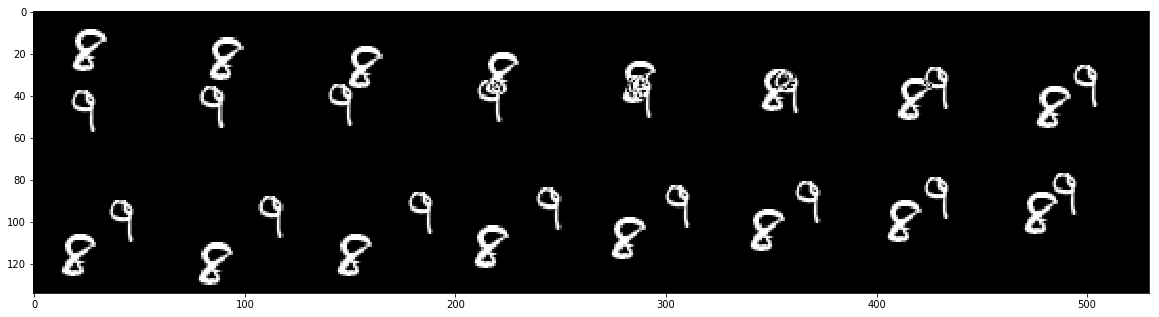

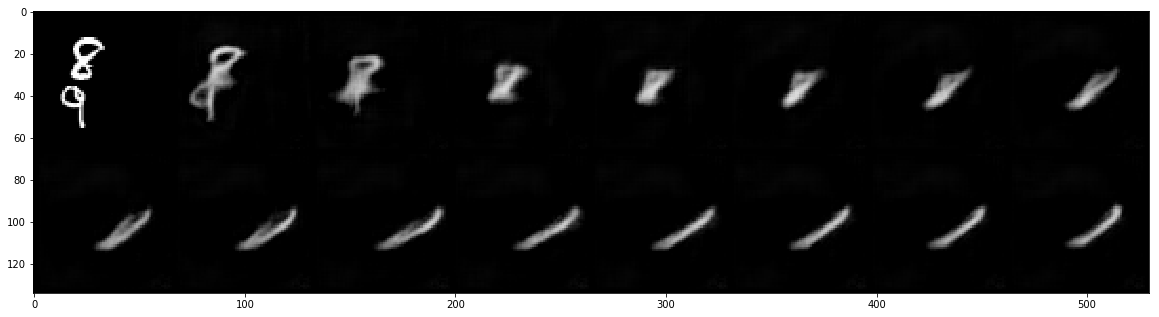

In [18]:
test_lstm_eval_2(gen, val_loader)